In [ ]:
!pip install --user keras tensorflow imagehash cleverhans numpy

In [3]:
from keras.models import load_model
from keras import backend
from keras.preprocessing.image import img_to_array, array_to_img
from keras.applications.mobilenet import decode_predictions, preprocess_input
from PIL import Image
from imagehash import phash
import numpy as np

In [4]:
IMAGE_DIMS = (224, 224)
TREE_FROG_IDX = 31
TREE_FROG_STR = "tree_frog"

In [5]:
# I'm pretty sure I borrowed this function from somewhere, but cannot remember
# the source to cite them properly.
def hash_hamming_distance(h1, h2):
    s1 = str(h1)
    s2 = str(h2)
    return sum(map(lambda x: 0 if x[0] == x[1] else 1, zip(s1, s2)))


def is_similar_img(path1, path2):
    image1 = Image.open(path1)
    image2 = Image.open(path2)

    dist = hash_hamming_distance(phash(image1), phash(image2))
    return dist <= 1

In [6]:
def prepare_image(image, target=IMAGE_DIMS):
    # if the image mode is not RGB, convert it
    if image.mode != "RGB":
        image = image.convert("RGB")

    # resize the input image and preprocess it
    image = image.resize(target)
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    # return the processed image
    return image

In [ ]:
model = load_model('./model.h5')
sess =  backend.get_session()

In [8]:
from cleverhans.attacks import FastGradientMethod
from cleverhans.attacks import BasicIterativeMethod
from cleverhans.utils_keras import KerasModelWrapper

from matplotlib import pyplot as plt

In [9]:
def labels_to_output_layer(labels):
    layers = np.zeros((len(labels), 1000))
    layers[np.arange(len(labels)), labels] = 1
    return layers

In [10]:
def gen_adv(img):
    wrap = KerasModelWrapper(model)
    bim = BasicIterativeMethod(wrap, sess=sess)
    border_color = 'black'
    output_layer = labels_to_output_layer([TREE_FROG_IDX])
    bim_params = {'eps_iter': 0.05,
                  'nb_iter': 25,
                  'y_target': output_layer
                 }
    adv_digit = bim.generate_np(img, **bim_params)
    return adv_digit

In [11]:
def get_predictions(image):
    preds = model.predict(image)
    print(preds.argmax(axis=-1))
    dec_preds = decode_predictions(preds)[0]
    #print(dec_preds)
    _, label1, conf1 = decode_predictions(preds)[0][0]
    return label1, conf1, dec_preds


In [20]:
def create_img(img_path, img_res_path, model_path, target_str, target_idx, des_conf=0.95):
    test = Image.open(img_path).resize(IMAGE_DIMS)
    test = prepare_image(test)

    test = gen_adv(test)
    print(get_predictions(test))
    
    test = test.reshape((224,224,3))
    img = array_to_img(test)
    plt.imshow(img)
    img.save(img_res_path)

[31]
('tree_frog', 1.0, [('n01644373', 'tree_frog', 1.0), ('n01644900', 'tailed_frog', 1.3510279e-14), ('n02168699', 'long-horned_beetle', 6.1273084e-15), ('n01694178', 'African_chameleon', 3.2709533e-15), ('n02169497', 'leaf_beetle', 1.9505619e-15)])
True


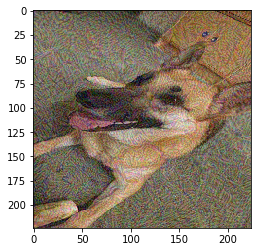

In [21]:
create_img("./trixi.png", "./trixi_frog.png", "./model.h5", TREE_FROG_STR, TREE_FROG_IDX)
print(is_similar_img("./trixi.png", "./trixi_frog.png"))